<a href="https://colab.research.google.com/github/wjdrnqja9/TIL/blob/main/CV/_classification%2BGradCAM_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import tensorflow as tf
# import os

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)

# strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
#import packages
import tensorflow as tf
import os

import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cv2 import imread, createCLAHE 
import cv2

from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img,img_to_array

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

import PIL
from PIL import Image

import imutils
from glob import glob


In [ ]:
img_path = '/content/drive/MyDrive/Python/이어드림스쿨/CV/ThyroidENE/'

In [ ]:
train_dir = img_path+'Train/'
test_dir = img_path+'Test/'

In [ ]:
#create classes
classes = os.listdir(train_dir)
print(classes)

['Benign', 'Cancer', 'CancerENE']


In [ ]:
files_path_dict = {}# 모든 training image 파일을 class별로 list를 만듬

for c in classes:
  if not c.startswith('.') :
    files_path_dict[c] = list(map(lambda x: train_dir + c + '/' + x, os.listdir(train_dir + c)))
   
  else :
    pass

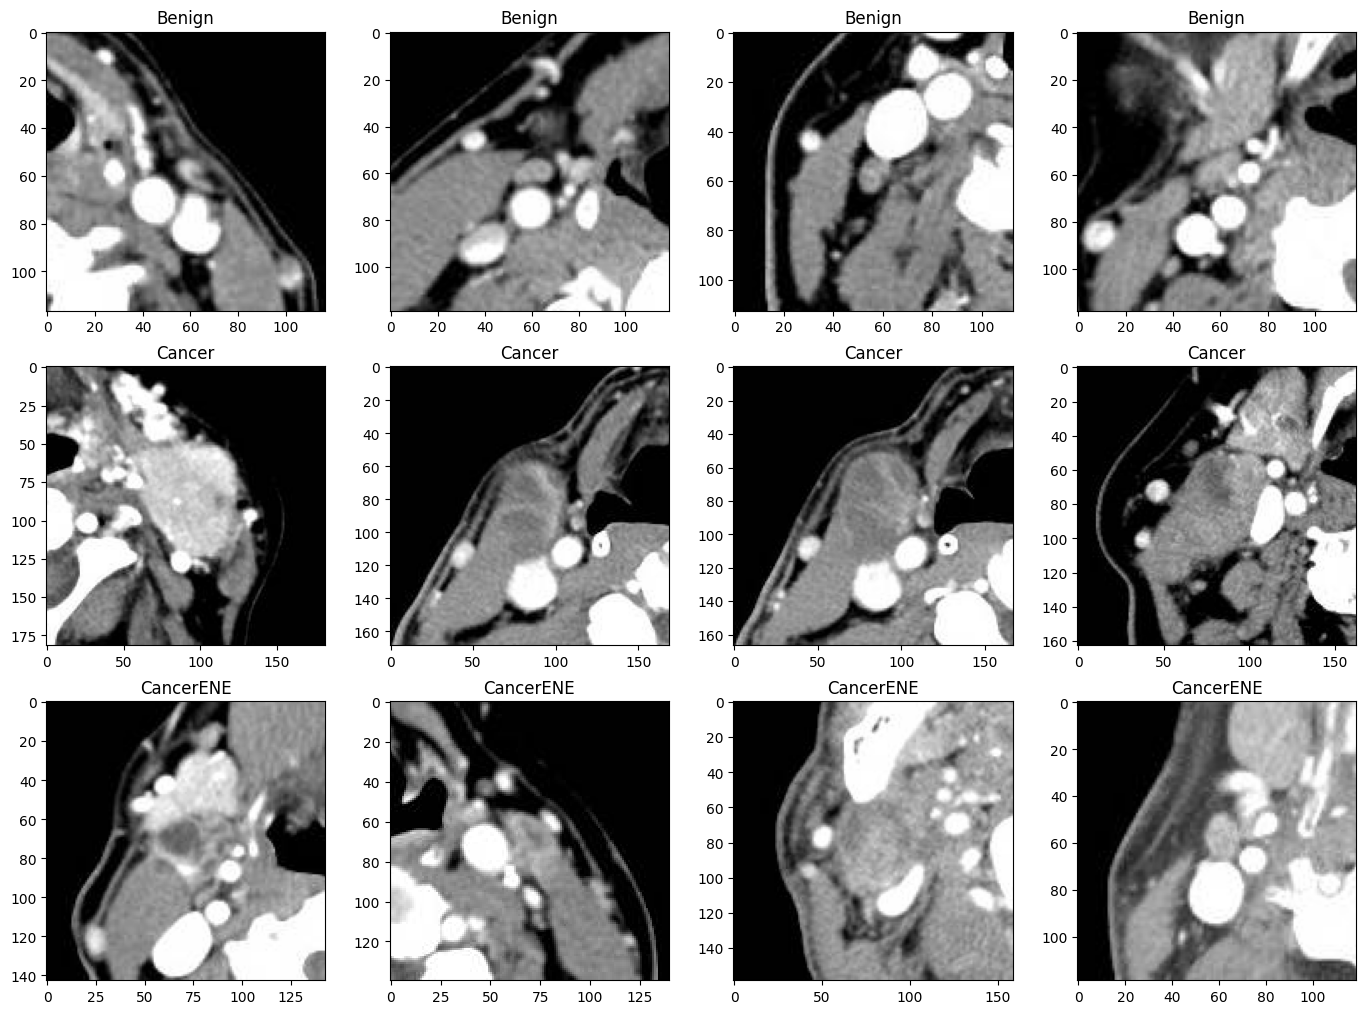

In [ ]:
#visualize
plt.figure(figsize = (17,17))
index = 0
for c in classes:
  if not c.startswith('.') :
    
    random.shuffle(files_path_dict[c])
    path_list = files_path_dict[c][:5]

    for i in range(1, 5):
      index += 1
      plt.subplot(4, 4, index)
      plt.imshow(load_img(path_list[i]))
      plt.title(c)
  else :
    pass

In [ ]:

#check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []

for i in os.listdir(train_dir):

  if not i.startswith('.') :
    train_class = os.listdir(os.path.join(train_dir, i))
    No_images_per_class.append(len(train_class))
    Class_name.append(i)
    print('Number of images in {} = {} \n'.format(i, len(train_class)))

   
  else :
    pass


Number of images in Benign = 600 

Number of images in Cancer = 294 

Number of images in CancerENE = 164 



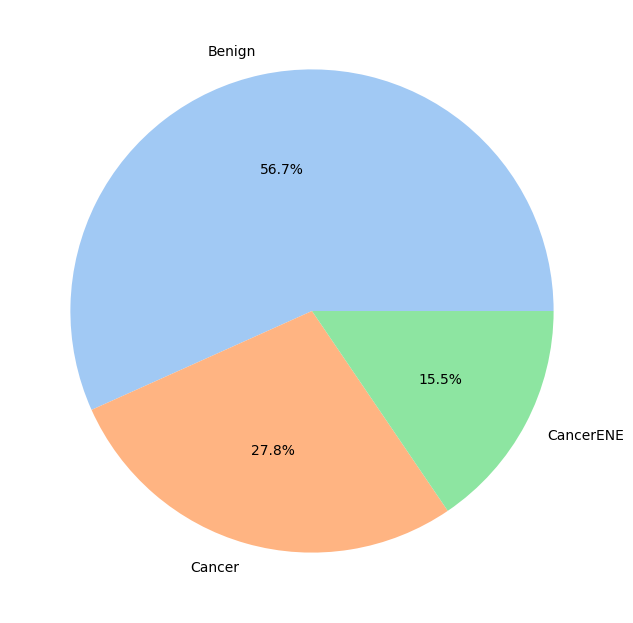

In [ ]:

#visualize class distribution in train set
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class, 
        labels = Class_name, 
        autopct = '%1.1f%%',
        colors=colors)
plt.show()


In [ ]:
# Crop image 를 저장하기 위한 폴더 생성

os.mkdir(img_path+'Crop')
os.mkdir(img_path+'Crop/Train')
os.mkdir(img_path+'Crop/Test')

for i in classes :
#create directory for training data
    os.mkdir(img_path+'Crop/Train/'+i)
    os.mkdir(img_path+'Crop/Test/'+i)


In [ ]:

def crop_image(image, plot=False):
    
    #convert to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #blur
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    #apply binary threshhold
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]

    #apply erosion
    img_thresh = cv2.erode(img_thresh, None, iterations=2)

    #dilate images
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    #find shapes or the contour of images
    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #grab contours
    contours = imutils.grab_contours(contours)

    #find biggest contour
    c = max(contours, key=cv2.contourArea)

    #extract contour positions
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #generate new image
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    #plot
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


In [ ]:

dims = 255

for x in classes :

  j = 0
  for i in tqdm(os.listdir(train_dir +x)):
    path = os.path.join(train_dir +x, i)
    img = cv2.imread(path)
    

    if img is not None:
      img = crop_image(img, plot=False)
      img = cv2.resize(img, (dims, dims))
      save_path = img_path+'Crop/Train/'+ x+'/' + str(j) + '.jpg'
      cv2.imwrite(save_path, img)
      j = j + 1

for x in classes :

  j = 0
  for i in tqdm(os.listdir(test_dir +x)):
    path = os.path.join(test_dir +x, i)
    img = cv2.imread(path)
    

    if img is not None:
      img = crop_image(img, plot=False)
      img = cv2.resize(img, (dims, dims))
      save_path = img_path+'Crop/Test/'+ x+'/' + str(j) + '.jpg'
      cv2.imwrite(save_path, img)
      j = j + 1



100%|██████████| 18/18 [00:05<00:00,  3.01it/s]


In [ ]:

#use Image Data Generator to perform this task
#train set
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

train_data = datagen.flow_from_directory(img_path+'Crop/Train/',
                                         target_size=(dims, dims),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='training')

valid_data = datagen.flow_from_directory(img_path+'Crop/Train/',
                                         target_size=(dims, dims),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='validation')

#test set
test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory(img_path+'Crop/Test/',
                                         target_size=(dims, dims),
                                        class_mode='categorical',
                                        shuffle=False)
                                        


Found 848 images belonging to 3 classes.
Found 210 images belonging to 3 classes.
Found 118 images belonging to 3 classes.


In [ ]:

#view the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)


{'Benign': 0, 'Cancer': 1, 'CancerENE': 2}
{'Benign': 0, 'Cancer': 1, 'CancerENE': 2}


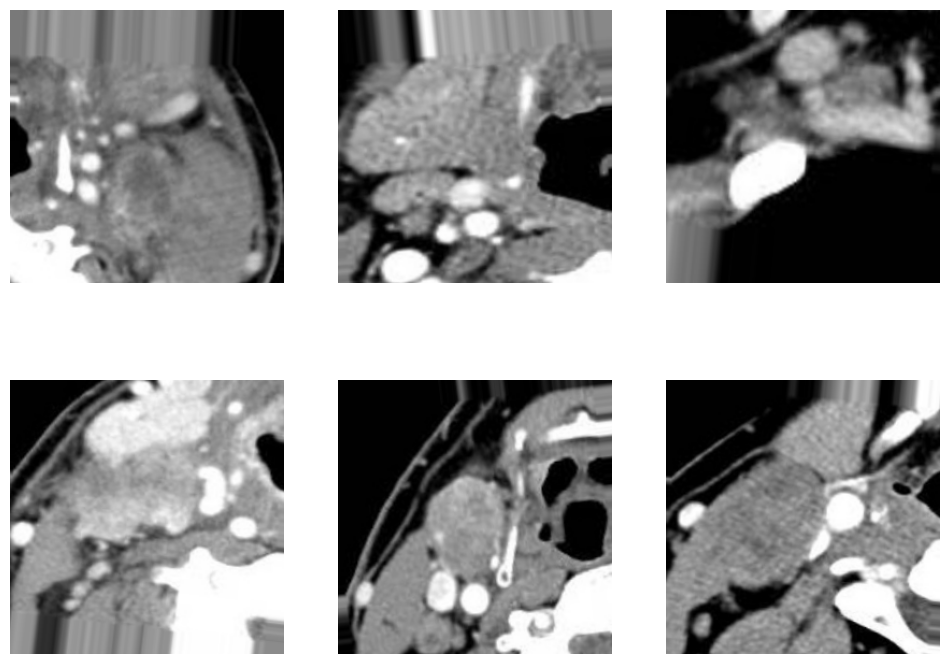

In [ ]:

#view the augmented data
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
#build the model

#availabe model : https://keras.io/api/applications/

CNNmodel = InceptionResNetV2(weights='imagenet', 
                        include_top=False, 
                        input_shape=(dims, dims, 3))

model = CNNmodel.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(len(classes), activation='softmax')(model)
model = Model(inputs=CNNmodel.input, 
              outputs=model)

#get summary()
model.summary()


Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 255, 255, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_609 (Conv2D)            (None, 127, 127, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_609 (Batch  (None, 127, 127, 32  96         ['conv2d_609[0][0]']             
 Normalization)                 )                                                          

In [ ]:

# compile model
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# define checkpoint
checkpoint = ModelCheckpoint('model.h5', 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:

#train the model
history = model.fit(train_data,
                    epochs = 30,
                    validation_data=valid_data,
                    verbose=1,
                    callbacks=[checkpoint, reduce_lr])#earlystop, ])


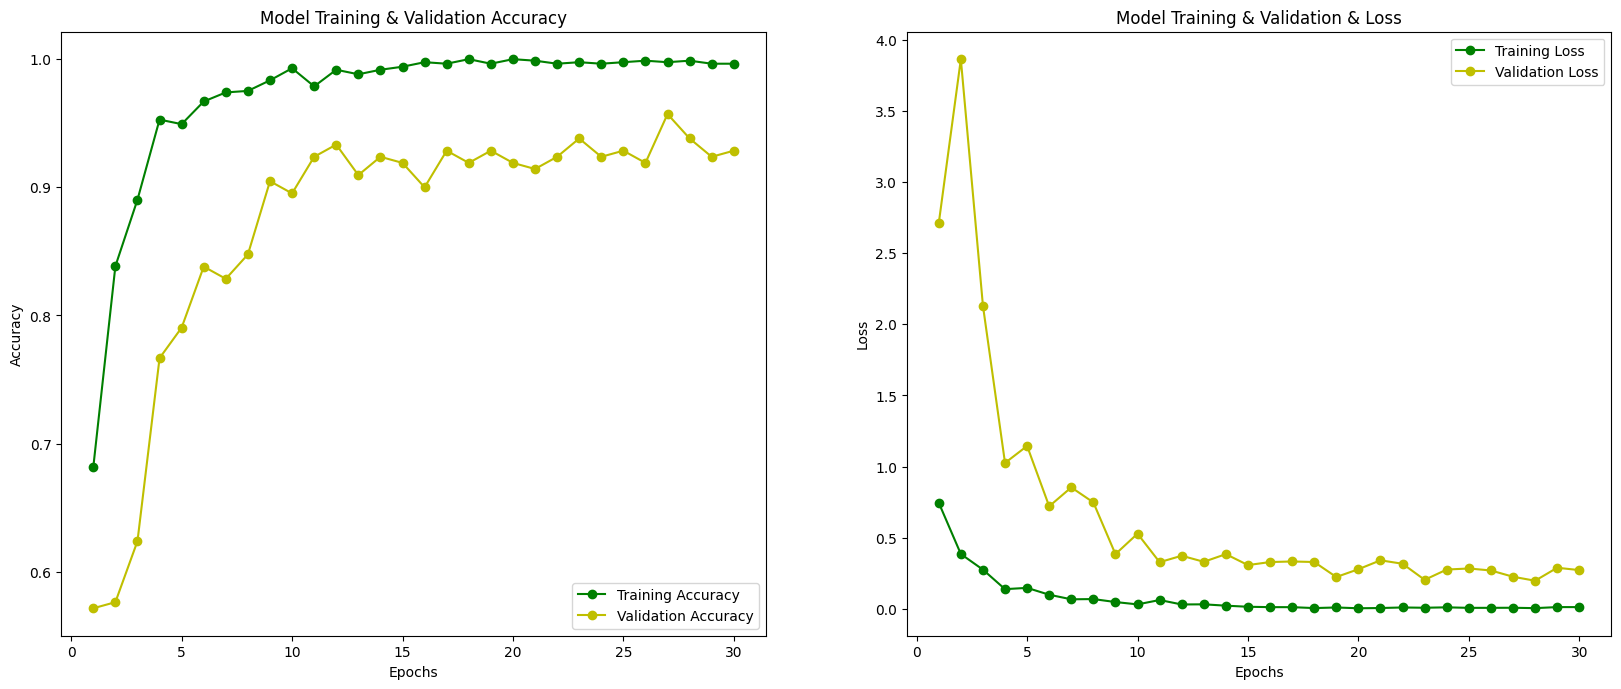

In [ ]:

fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()


In [ ]:

print('Train loss & accuracy :', model.evaluate(train_data))
print('\n')
print('Test loss & accuracy :', model.evaluate(test_data))


27/27 [==============================] - 12s 441ms/step - loss: 0.0013 - accuracy: 1.0000
Train loss & accuracy : [0.0013008089736104012, 1.0]


4/4 [==============================] - 2s 503ms/step - loss: 0.6264 - accuracy: 0.8390
Test loss & accuracy : [0.6264294385910034, 0.8389830589294434]


In [ ]:

#define labels for testing
y_test = test_data.classes

#make prediction
yhat_test = np.argmax(model.predict(test_data), axis=1)


[[63  2  2]
 [ 0 28  5]
 [ 0 12  6]]


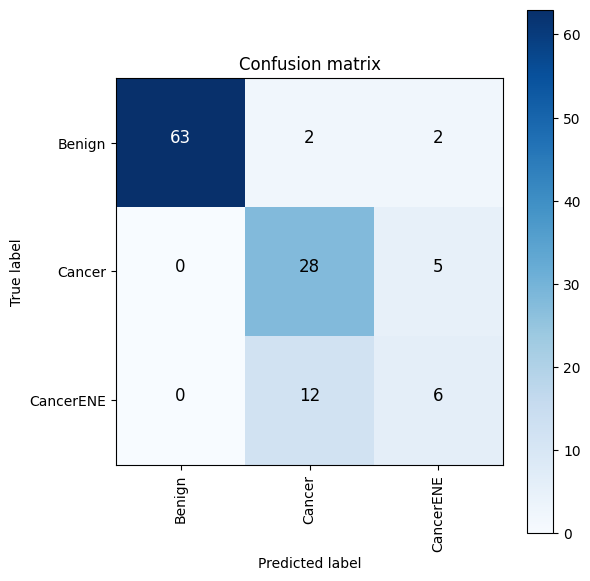

In [ ]:

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
      
#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)


In [ ]:
#get classification report
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        67
           1       0.67      0.85      0.75        33
           2       0.46      0.33      0.39        18

    accuracy                           0.82       118
   macro avg       0.71      0.71      0.70       118
weighted avg       0.82      0.82      0.82       118



In [ ]:
reverse_dict= dict(map(reversed,test_data.class_indices.items()))

In [ ]:

#https://github.com/gkeechin/vizgradcam/blob/main/gradcam.py

def VizGradCAM(model, image, interpolant=0.5, plot_results=True):

    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"
    
    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    
    #expamd dimension and get batch size
    img = np.expand_dims(original_img, axis=0)
    
    #predict
    prediction = model.predict(img)
    
    #prediction index
    prediction_idx = np.argmax(prediction)
    
    #STEP 2: Create new model
    #specify last convolutional layer
    # last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D))
    
    
    target_layer = model.get_layer(last_conv_layer.name)
    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map  
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        loss = prediction[:, prediction_idx]
    #gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)
    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]
    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))
    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    #resize to image size
    activation_map = cv2.resize(activation_map.numpy(), 
                                (original_img.shape[1], 
                                 original_img.shape[0]))
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)
    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)
    #enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img))
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
        print(f"Prediction = {reverse_dict[np.argmax(prediction)]}")
        # print(test_data.class_indices.keys(np.argmax(prediction)))
        
    else:
        return cvt_heatmap


Original = Benign
Prediction = Benign


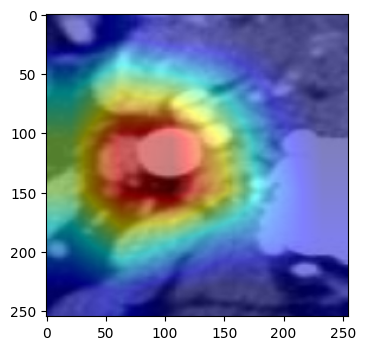

In [ ]:
from tensorflow import keras as K

#load image
test_img = cv2.imread(img_path+"Crop/Test/"+ classes[0] + "/8.jpg")

#apply function
print(f"Original = {classes[0]}")
VizGradCAM(model, img_to_array(test_img), plot_results=True)

Original = Cancer
Prediction = Cancer


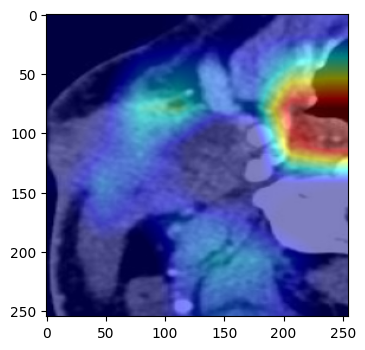

In [ ]:
from tensorflow import keras as K

#load image
test_img = cv2.imread(img_path+"Crop/Test/"+ classes[1] + "/17.jpg")

#apply function
print(f"Original = {classes[1]}")
VizGradCAM(model, img_to_array(test_img), plot_results=True)

Original = CancerENE
Prediction = Cancer


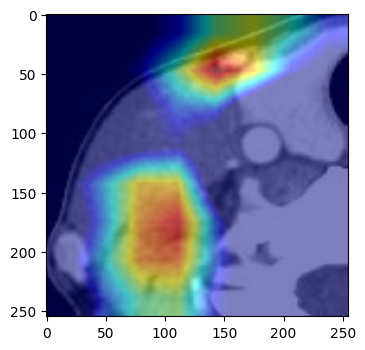

In [ ]:
from tensorflow import keras as K

#load image
test_img = cv2.imread(img_path+"Crop/Test/"+ classes[2] + "/5.jpg")

#apply function
print(f"Original = {classes[2]}")
VizGradCAM(model, img_to_array(test_img), plot_results=True)

In [ ]:
# import cv2
# import sys
             
# for i in os.listdir(img_path+'Test-Data/new_test'):   
#   if not i.startswith('.') :
#     # code to open the image
#     example_image = cv2.imread(os.path.join(img_path+'Test-Data/new_test', i))
#     img = cv2.resize(example_image, (240, 240))

#     #apply function
#     VizGradCAM(model, img_to_array(img), plot_results=True)
    
#     img= np.expand_dims(example_image, axis=0)
#     predict = model.predict(img)
#     predict = np.argmax(predict)
#     print(class_dict[predict])    
#   else :
#     pass
